An example for using SBINF (Simulation Based Inference with Normalising Flows)

We find an approximation of the posterior $P(\theta|x)$, where $\theta$ are the model parameters and $x$ are the model features.

In [2]:
from sbinf import InferenceModel
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

device = torch.device('cuda:0')

### Mock Data ND

In [14]:
num_mocks = 1000
num_parameters = 4
num_features = 5

def simulation(theta):
    num_sims = theta.shape[0]
    outputs = torch.zeros(num_mocks, num_features)
    for i in range(num_features):
        outputs[:, i] = torch.normal(theta[:, i % num_parameters]**(i+1), torch.ones_like(theta[:, 0]) * 0.1)
    return outputs
    
# choose our simulation grid
mock_targets = (torch.rand((num_mocks, num_parameters)) - 0.5) * 2

# 'run' the simulations
mock_features = simulation(mock_targets)  # x

# reshape into data vectors
print(mock_targets.shape, mock_features.shape)

torch.Size([1000, 4]) torch.Size([1000, 5])


This is the same thing, but in N-dimensions. Each $x_i$ is dependent on the corresponding $\theta_i$, and $x_5$ is dependent on $\theta_1$

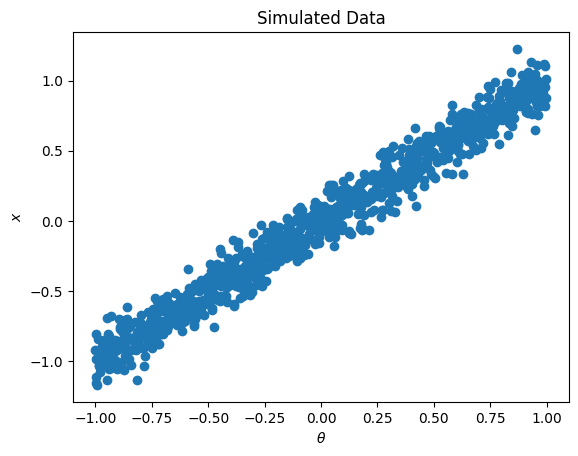

In [15]:
plt.scatter(mock_targets[:, 0], mock_features[:, 0])
plt.xlabel('$\\theta$')
plt.ylabel('$x$')
plt.title('Simulated Data')
plt.show()

### Use SBINF to Model the Distribution

Beginning training for 100 epochs

Epoch 1 	| Train Loss: 3.840e+00 	| Val Loss: 3.393e+00
Epoch 11 	| Train Loss: -8.243e-01 	| Val Loss: -6.085e-01
Epoch 21 	| Train Loss: -1.432e+00 	| Val Loss: -1.176e+00
Epoch 31 	| Train Loss: -1.698e+00 	| Val Loss: -1.474e+00
Epoch 41 	| Train Loss: -1.822e+00 	| Val Loss: -1.556e+00
Epoch 51 	| Train Loss: -1.946e+00 	| Val Loss: -1.568e+00
Epoch 61 	| Train Loss: -1.961e+00 	| Val Loss: -1.331e+00
Epoch 71 	| Train Loss: -2.045e+00 	| Val Loss: -1.518e+00
Epoch 81 	| Train Loss: -2.131e+00 	| Val Loss: -1.546e+00
Epoch 91 	| Train Loss: -2.194e+00 	| Val Loss: -1.490e+00

Training complete. Final train loss: -2.187e+00 | Final val loss: -1.581e+00


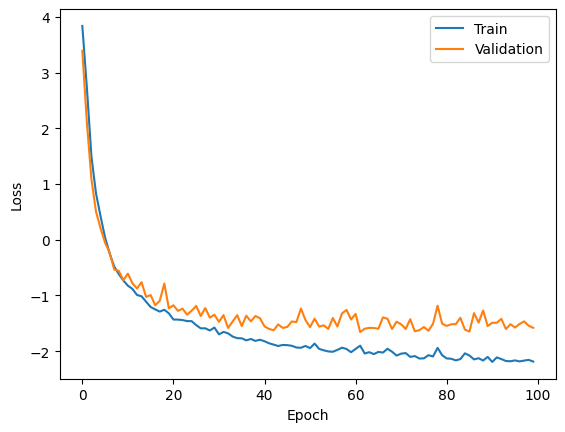

In [21]:
# instantiate model
model = InferenceModel(num_hidden_layers=2, num_flow_layers=8, num_hidden_units=256)

# add the simulatioed features and targets
model.add_simulations(mock_features, mock_targets)

# setup the model
model.setup(device=device)

# train the inference model
model.train_model(num_epochs=100, lr=1e-4)

model.show_loss()

### Sample the learned distribution

In [22]:
# example observational feature
num_samples = 20000
observed_features = torch.tensor([0.5,]*num_features).unsqueeze(0).to(device)
observed_features = observed_features.repeat(num_samples, 1)
print(observed_features.shape)
print(mock_features.shape)

samples = model.sample(num_samples, observed_features)[0].cpu().detach()

torch.Size([20000, 5])
torch.Size([1000, 5])


Plotting the distribution along the slice shows a pretty good reconstruction!

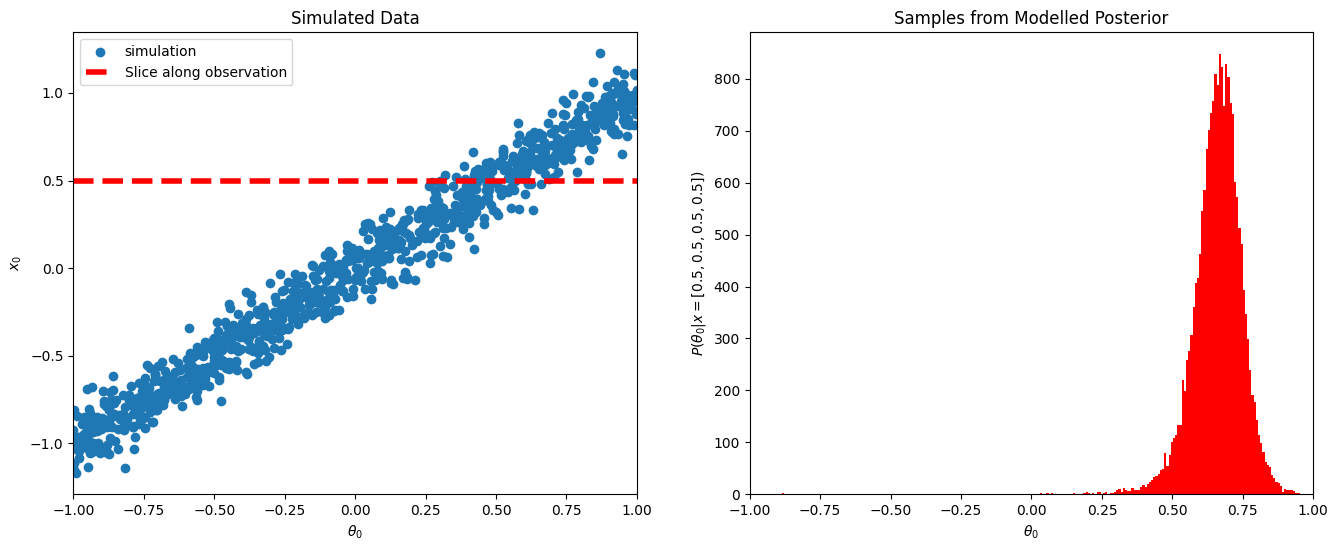

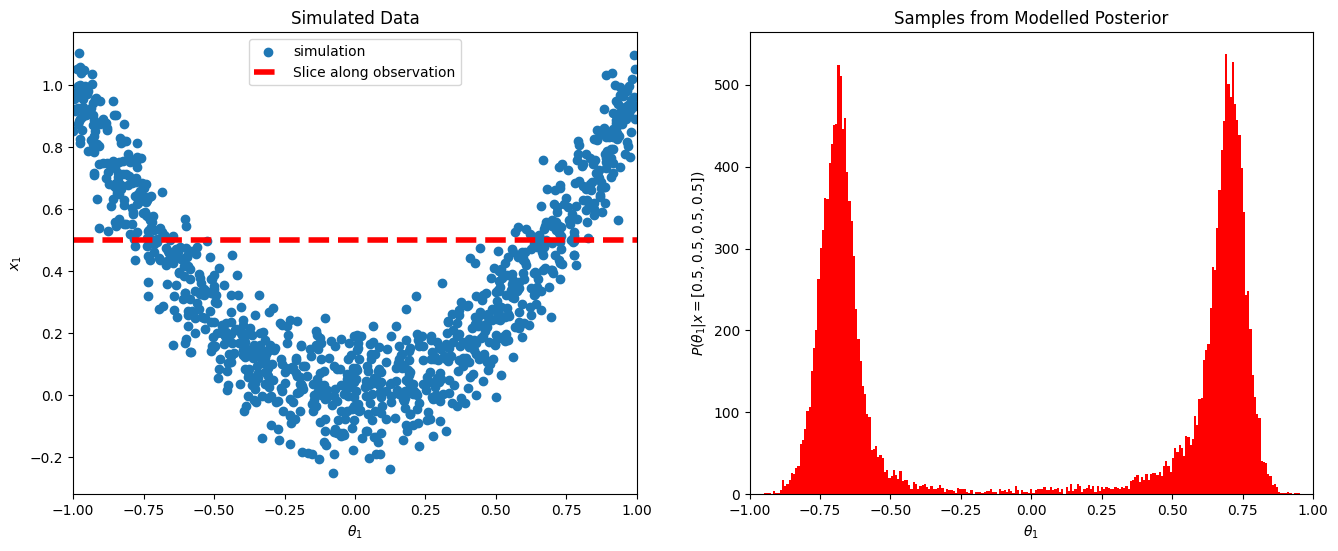

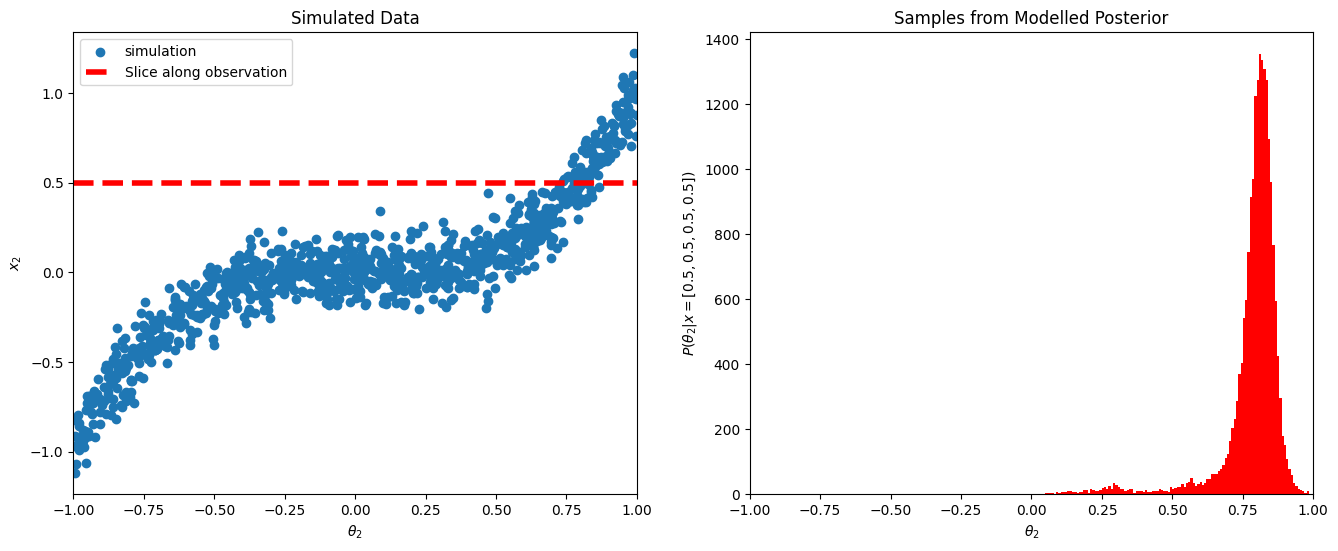

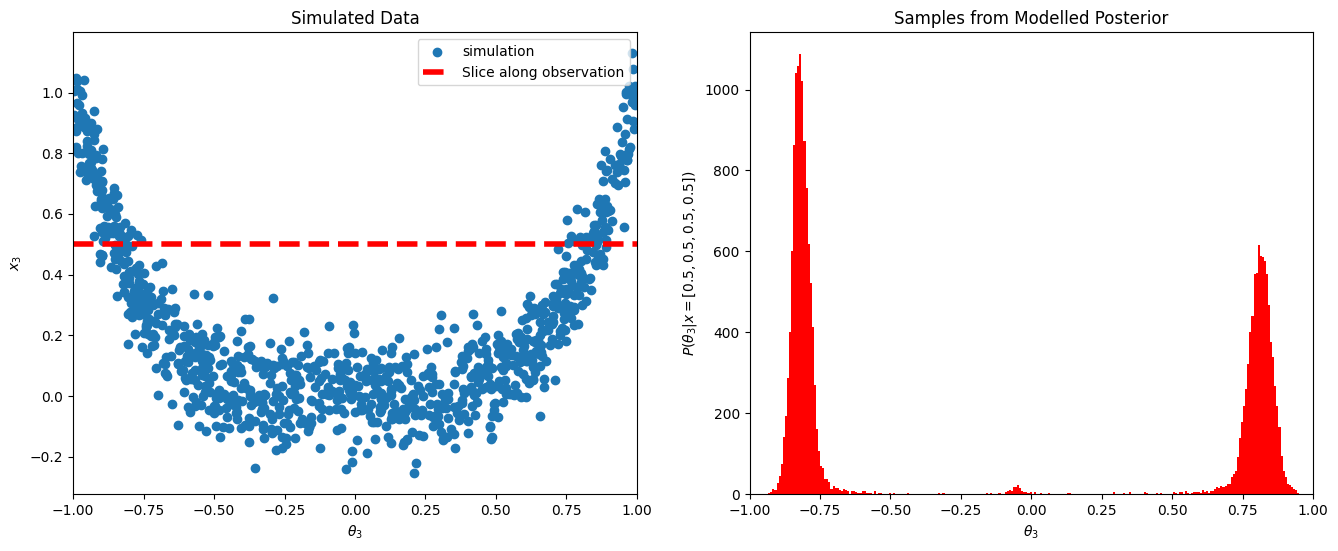

In [23]:
for param in range(num_parameters):

    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
    axes[0].scatter(mock_targets[:, param], mock_features[:, param], label='simulation')
    axes[0].set_xlabel('$\\theta_{}$'.format(param))
    axes[0].set_ylabel('$x_{}$'.format(param))
    axes[0].set_title('Simulated Data')
    axes[0].set_xlim(-1, 1)
    axes[0].plot([-1, 1], [0.5, 0.5], c='red', linewidth=4, linestyle='--', label='Slice along observation')
    axes[0].legend()
    
    axes[1].set_title('Samples from Modelled Posterior')
    axes[1].hist(samples[:, param], bins=1000, color='red')
    axes[1].set_xlim(-1, 1)
    axes[1].set_ylabel('$P(\\theta_{}|x=[0.5, 0.5, 0.5, 0.5]$)'.format(param, param))
    axes[1].set_xlabel('$\\theta_{}$'.format(param))
    plt.show()

### Contours

We can't do the density plot in N-dimensions, but we can do contours! The normalising flow works beautifully in this high-dimensional space. 

torch.Size([20000, 4])


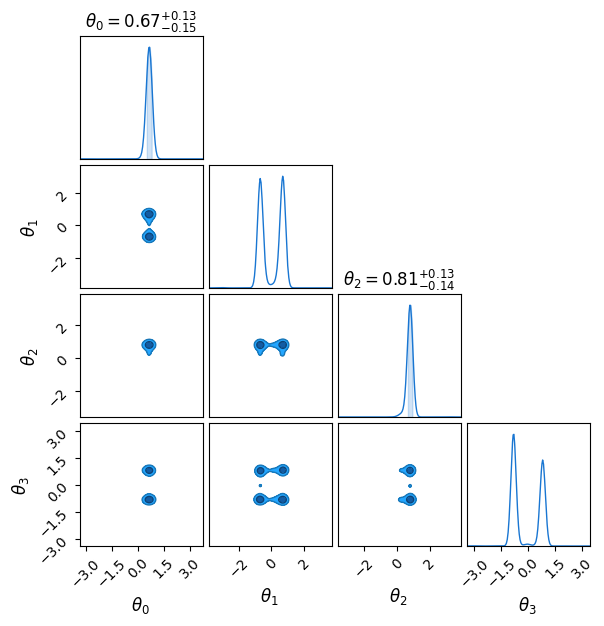

In [25]:
c = ChainConsumer()
param_names = ['$\\theta_{}$'.format(i) for i in range(4)]
print(samples.shape)
c.add_chain(samples.numpy(), parameters=param_names)
c.plotter.plot();